In [0]:
!pip install geopandas
!pip install descartes
!pip install mplleaflet
!pip install seaborn

  Created wheel for mplleaflet: filename=mplleaflet-0.0.5-cp36-none-any.whl size=28555 sha256=e34a54e5df2dc10b82ac1a9139da5faecf6392199b09106ddafc1a0e830a7531
  Stored in directory: /root/.cache/pip/wheels/bf/fd/0b/0513de62c339c4a56e2234aa42a5d06e6660a4446fdae7b796
Successfully built mplleaflet


In [0]:
import numpy as np
import pandas as pd
import geopandas as gpd
from functools import reduce 

import time

import matplotlib as mp
import matplotlib.pyplot as plt
import mplleaflet
import descartes
import seaborn as sns
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
sns.set(font_scale=2)

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
from google.cloud import bigquery
client = bigquery.Client('thesisprojects2019')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### England County Maps - Event and Venue Profile


In [0]:
#import london statistic table from bigquery
query = """ SELECT * FROM `thesisprojects2019.audeMS.step10_eventtype_county_homelocation_spectatorswithhome` 
                 ORDER BY event_type, county_id """
data = client.query(query).to_dataframe()

In [0]:
data['venue_eventtype'] = data[['event_type', 'venue']].apply(lambda x: ' - '.join(x), axis=1)
data.head(2)

,venue,event_type,county_id,county_name,count_spect_county,perc_spectators_county,venue_eventtype
0,wembley stadium,Champions League,E06000004,Stockton-on-Tees,1,0.04,Champions League - wembley stadium
1,wembley stadium,Champions League,E06000015,Derby,1,0.04,Champions League - wembley stadium


In [0]:
venue_eventtype_list = []
for i in data.venue_eventtype:
    if i not in venue_eventtype_list:
        venue_eventtype_list.append(i)

In [0]:
#import the london shapefiles from GoogleDrive
pathdrive = 'drive/My Drive/Colab Notebooks/Shapefiles/County/Counties_and_Unitary_Authorities_December_2015_Ultra_Generalised_Clipped_Boundaries_in_England_and_Wales.shp'
geom_data = gpd.read_file(pathdrive)

In [0]:
geom_data.head(2)

,ctyua15cd,ctyua15nm,ctyua15nmw,objectid,st_lengths,st_areasha,geometry
0,E06000001,Hartlepool,None,1,50778.093996,9.633958e+07,"POLYGON ((448906.5049000001 536702.9926999994,..."
1,E06000002,Middlesbrough,None,2,35500.301293,5.523094e+07,"POLYGON ((451894.2999999998 521145.3000000007,..."


In [0]:
# CRS for County
crs = {'init': 'epsg:4326'}
county = geom_data.to_crs({'init':'epsg:27700'})

# rename the columns
county = county.rename(columns={'ctyua15nm':'county_name','ctyua15cd':'county_id'})
# Select only the columns of interest
county = county[['county_id','county_name','geometry']]

In [0]:
#def GetDataFrame(datasource):
  # Selection event
for e in venue_eventtype_list:
    # Mergedata 
    dataevent = data[data['venue_eventtype']==e]
    datajoin = pd.merge(dataevent,county,how='right',on=['county_id'])
    datajoin = datajoin[['venue','event_type','venue_eventtype','county_id','county_name_x','perc_spectators_county','geometry']]
    
    # select the event name
    eventname = datajoin['venue_eventtype'][0]
    
    # change to gdp
    gpd_df = gpd.GeoDataFrame(datajoin, geometry='geometry', crs={'init': 'epsg:27700'})
      
    # If NaN -> change it to 0!   
    values = {'venue': 0, 'event_type':0,'perc_spectators_county':0}  
    gpd_df = gpd_df.fillna(value=values)
      
    # Selection the variable to plot
    var_map = gpd_df['perc_spectators_county']
      
    # Set the range for the choropleth
    vmin = gpd_df['perc_spectators_county'].min()
    vmax = gpd_df['perc_spectators_county'].max()
      
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(8, 10), dpi=140)
   # fig, ax = plt.subplots(1, figsize=(8, 10),dpi=140)
 
    # create map
    gpd_df.plot(column=var_map, cmap='YlGn', linewidth=0.6, ax=ax, edgecolor='0.8')
    
    plt.title(str(eventname) + ' - Catchment Area', fontsize=14, horizontalalignment='center')
    plt.xlabel('Longitude',fontsize=12, horizontalalignment='center')
    plt.ylabel('Latitude',fontsize=12, horizontalalignment='center')
    plt.xticks(horizontalalignment='center', fontsize=9)
    plt.yticks(horizontalalignment='right', fontsize=9)
    
    ax.tick_params(axis='both', which='major', pad=6)
    
    sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    cbar = fig.colorbar(sm, orientation='horizontal',fraction=0.04, pad=0.09)
    cbar.set_label('% Spectators (in total of home Spectators)', size=11)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=10)
     
    fig.tight_layout()
    
    plt.savefig('drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/County/'+str(eventname)+'.png')
    
    plt.close('all')
   # plt.show()

In [0]:
#Download images into google drive
from google.colab import files
import os

folderpath = '/content/drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/County'

for filename in os.listdir(folderpath):
 # print(filename)
  files.download(folderpath+'/'+str(filename))

### England District Maps - Event and Venue Profile


In [0]:
#import london statistic table from bigquery
query = """ SELECT * FROM `thesisprojects2019.audeMS.step10_eventtype_district_homelocation_spectatorswithhome` 
                 ORDER BY event_type, district_id """
data = client.query(query).to_dataframe()

In [0]:
data['venue_eventtype'] = data[['event_type', 'venue']].apply(lambda x: ' - '.join(x), axis=1)
data.head(2)

,venue,event_type,district_id,district_name,count_spect_district,perc_spectators_district,venue_eventtype
0,wembley stadium,Champions League,E06000004,Stockton-on-Tees,1,0.04,Champions League - wembley stadium
1,wembley stadium,Champions League,E06000015,Derby,1,0.04,Champions League - wembley stadium


In [0]:
#import the district shapefiles from GoogleDrive
pathdrive = 'drive/My Drive/Colab Notebooks/Shapefiles/District/Local_Authority_Districts_December_2017_Super_Generalised_Clipped_Boundaries_in_Great_Britain.shp'
geom_data = gpd.read_file(pathdrive)
geom_data.head(2)

,objectid,lad17cd,lad17nm,lad17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
0,1,E06000001,Hartlepool,None,447157,531476,-1.27023,54.676159,9.365265e+07,59467.502291,"POLYGON ((447851.2015000004 537036.0043000001,..."
1,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,54.544670,5.410254e+07,38474.532954,MULTIPOLYGON (((450791.1017000005 520932.50390...


In [0]:
# CRS for London Ward
crs = {'init': 'epsg:4326'}
district = geom_data.to_crs({'init':'epsg:27700'})

# rename the columns
district = district.rename(columns={'lad17nm':'district_name','lad17cd':'district_id'})
# Select only the columns of interest
district = district[['district_id','district_name','geometry']]

In [0]:
#def GetDataFrame(datasource):
  # Selection event
for e in venue_eventtype_list:
    # Mergedata 
    dataevent = data[data['venue_eventtype']==e]
    datajoin = pd.merge(dataevent,district,how='right',on=['district_id'])
    datajoin = datajoin[['venue','event_type','venue_eventtype','district_id','district_name_x','perc_spectators_county','geometry']]
    
    # select the event name
    eventname = datajoin['venue_eventtype'][0]
    
    # change to gdp
    gpd_df = gpd.GeoDataFrame(datajoin, geometry='geometry', crs={'init': 'epsg:27700'})
      
    # If NaN -> change it to 0!   
    values = {'venue': 0, 'event_type':0,'perc_spectators_county':0}  
    gpd_df = gpd_df.fillna(value=values)
      
    # Selection the variable to plot
    var_map = gpd_df['perc_spectators_county']
      
    # Set the range for the choropleth
    vmin = gpd_df['perc_spectators_county'].min()
    vmax = gpd_df['perc_spectators_county'].max()
      
    # create figure and axes for Matplotlib
   # fig, ax = plt.subplots(1, figsize=(8, 10), dpi=140)
    fig, ax = plt.subplots(1, figsize=(8, 10))
 
    # create map
    gpd_df.plot(column=var_map, cmap='YlGn', linewidth=0.6, ax=ax, edgecolor='0.8')
    
    plt.title(str(eventname) + ' - Catchment Area', fontsize=14, horizontalalignment='center')
    plt.xlabel('Longitude',fontsize=12, horizontalalignment='center')
    plt.ylabel('Latitude',fontsize=12, horizontalalignment='center')
    plt.xticks(horizontalalignment='center', fontsize=9)
    plt.yticks(horizontalalignment='right', fontsize=9)
    
    ax.tick_params(axis='both', which='major', pad=6)
    
    sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    cbar = fig.colorbar(sm, orientation='horizontal',fraction=0.04, pad=0.09)
    cbar.set_label('% Spectators (in total of home Spectators)', size=11)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=10)
     
    fig.tight_layout()
    
   # plt.savefig('drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/District/'+str(eventname)+'.png')
    
  #  plt.close('all')
    plt.show()

### England District Maps - Event and Venue Profile
### District Selection

In [0]:
#SELECT only the districts around London
select_district = ['South Bucks', 'Chiltern','Wycombe','Aylesbury Vale','Hastings','Rother','Wealden','Eastbourne','Lewes',
                  'Harlow','Epping Forest','Brentwood','Basildon','Castle Point','Rochford','Maldon','Chelmsford','Uttlesford','Braintree','Colchester','Tendring',
                  'Gosport','Fareham','Winchester','Havant','East Hampshire','Hart','Rushmoor','Basingstoke and Deane','Test Valley','Eastleigh','New Forest',
                  'Three Rivers','Watford','Hertsmere','Welwyn Hatfield','Broxbourne','East Hertfordshire','Stevenage','North Hertfordshire','St Albans',
                  'Dacorum','Dartford','Gravesham','Sevenoaks','Tonbridge and Malling','Tunbridge Wells','Maidstone','Swale','Ashford','Folkestone and Hythe',
                  'Canterbury','Dover','Thanet','Oxford','Cherwell','South Oxfordshire','Vale of White Horse','West Oxfordshire','Spelthorne','Runnymede', 
                  'Surrey Heath','Woking','Elmbridge','Guildford','Waverley','Mole Valley','Epsom and Ewell','Reigate and Banstead','Tandridge','Worthing',
                  'Arun','Chichester','Horsham','Crawley','Mid Sussex','Adur','City of London','Westminster','Kensington and Chelsea','Hammersmith and Fulham',
                  'Wandsworth','Lambeth','Southwark','Tower Hamlets','Hackney','Islington','Camden','Brent','Ealing','Hounslow','Richmond upon Thames',
                  'Kingston upon Thames','Merton','Sutton','Croydon','Bromley','Lewisham','Greenwich','Bexley','Havering','Barking and Dagenham',
                  'Redbridge','Newham','Waltham Forest','Haringey','Enfield','Barnet','Harrow','Hillingdon','Bracknell Forest','Reading','Slough',
                  'West Berkshire','Windsor and Maidenhead','Wokingham','Milton Keynes','Bedford','Central Bedfordshire','Luton','Southend-on-Sea',
                   'Thurrock','Medway','Brighton and Hove','Portsmouth','Southampton','South Cambridgeshire','Cambridge','Shepway']

In [0]:
# Create a new Geopandas Dataframe for only the district we are interested in!
new_gpd_list = []
for i in select_district:
    new = district[district['district_name']== i]
    new_gpd_list.append(new)
    new_gpd = pd.concat(new_gpd_list)

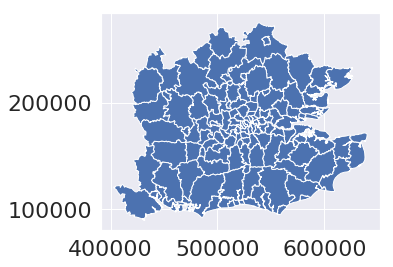

In [0]:
crs = {'init': 'epsg:4326'}
new_gpd = new_gpd.to_crs({'init':'epsg:27700'})
new_gpd.plot()

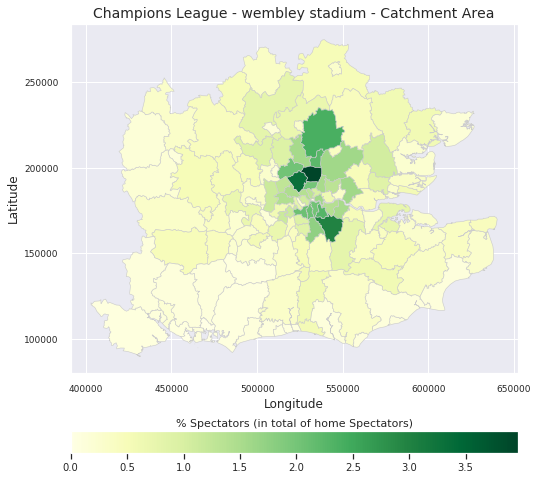

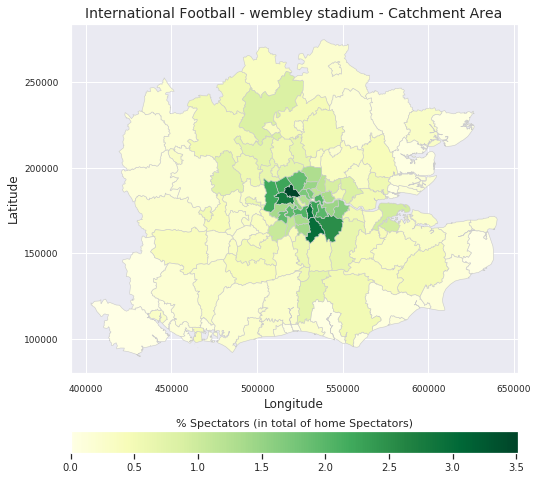

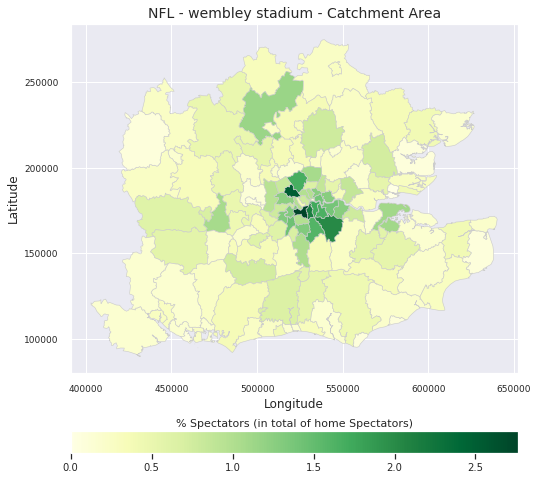

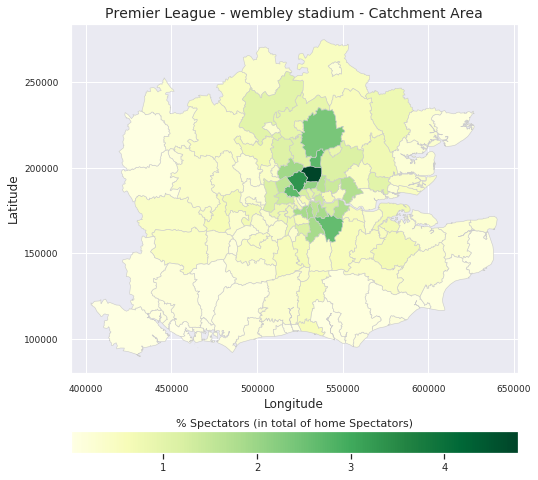

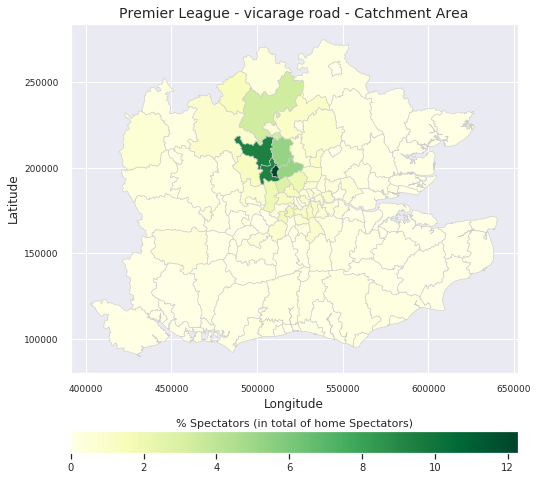

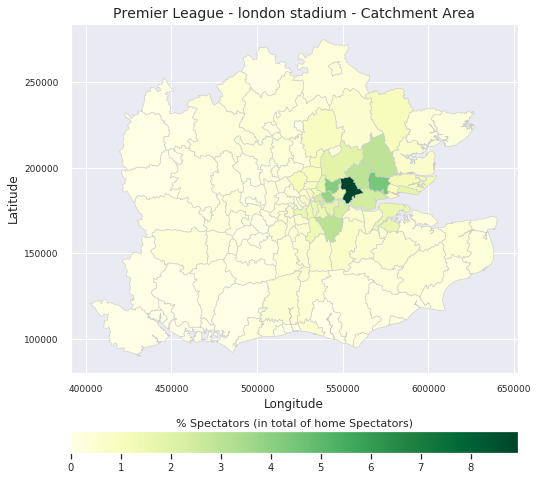

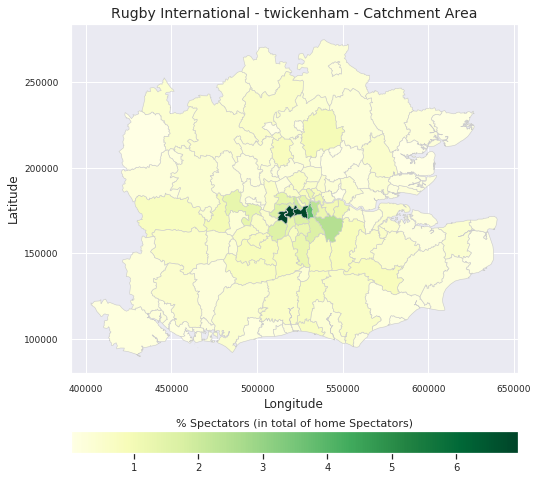

In [0]:
#def GetDataFrame(datasource):
  # Selection event
for e in venue_eventtype_list:
    # Mergedata 
    dataevent = data[data['venue_eventtype']==e]
    datajoin = pd.merge(dataevent,new_gpd,how='right',on=['district_id'])
    datajoin = datajoin[['venue','event_type','venue_eventtype','district_id','district_name_x','perc_spectators_district','geometry']]
    
    # select the event name
    eventname = datajoin['venue_eventtype'][0]
    
    # change to gdp
    gpd_df = gpd.GeoDataFrame(datajoin, geometry='geometry', crs={'init': 'epsg:27700'})
      
    # If NaN -> change it to 0!   
    values = {'venue': 0, 'event_type':0,'perc_spectators_district':0}  
    gpd_df = gpd_df.fillna(value=values)
      
    # Selection the variable to plot
    var_map = gpd_df['perc_spectators_district']
      
    # Set the range for the choropleth
    vmin = gpd_df['perc_spectators_district'].min()
    vmax = gpd_df['perc_spectators_district'].max()
      
    # create figure and axes for Matplotlib
    #fig, ax = plt.subplots(1, figsize=(8, 10), dpi=140)
    fig, ax = plt.subplots(1, figsize=(8, 10))
 
    # create map
    gpd_df.plot(column=var_map, cmap='YlGn', linewidth=0.6, ax=ax, edgecolor='0.8')
    
    plt.title(str(eventname) + ' - Catchment Area', fontsize=14, horizontalalignment='center')
    plt.xlabel('Longitude',fontsize=12, horizontalalignment='center')
    plt.ylabel('Latitude',fontsize=12, horizontalalignment='center')
    plt.xticks(horizontalalignment='center', fontsize=9)
    plt.yticks(horizontalalignment='right', fontsize=9)
    
    ax.tick_params(axis='both', which='major', pad=6)
    
    sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    cbar = fig.colorbar(sm, orientation='horizontal',fraction=0.04, pad=0.09)
    cbar.set_label('% Spectators (in total of home Spectators)', size=11)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=10)
     
    fig.tight_layout()
    
  #  plt.savefig('drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/District_Selection/'+str(eventname)+'.png')
    
  #  plt.close('all')
    plt.show()

In [0]:
#Download images into google drive
from google.colab import files
import os

folderpath = '/content/drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/District_Selection'

for filename in os.listdir(folderpath):
 # print(filename)
  files.download(folderpath+'/'+str(filename))

### London Wards Maps - Event and Venue Profile

In [0]:
#import london statistic table from bigquery
query = """ SELECT * FROM `thesisprojects2019.audeMS.step10_eventtype_london_homelocation_spectatorswithhome` 
                 ORDER BY event_type, ward_id """
data = client.query(query).to_dataframe()

In [0]:
data['venue_eventtype'] = data[['event_type', 'venue']].apply(lambda x: ' - '.join(x), axis=1)
data.head(2)

,venue,event_type,ward_id,ward_name,count_spect_london,perc_spectators_london,venue_eventtype
0,wembley stadium,Champions League,E05000028,Becontree,1,0.04,Champions League - wembley stadium
1,wembley stadium,Champions League,E05000030,Eastbrook,3,0.12,Champions League - wembley stadium


In [0]:
#import the london shapefiles from GoogleDrive
pathdrive = 'drive/My Drive/Colab Notebooks/Shapefiles/London/London_Ward_CityMerged.shp'
geom_data = gpd.read_file(pathdrive)
geom_data.head(2)

,NAME,GSS_CODE,DISTRICT,LAGSSCODE,HECTARES,NONLD_AREA,geometry
0,Chessington South,E05000405,Kingston upon Thames,E09000021,755.173,0.0,"POLYGON ((516401.5959642464 160201.8020401799,..."
1,Tolworth and Hook Rise,E05000414,Kingston upon Thames,E09000021,259.464,0.0,"POLYGON ((519552.9984840818 164295.60020387, 5..."


In [0]:
# CRS for London Ward
crs = {'init': 'epsg:4326'}
lnd_ward = geom_data.to_crs({'init':'epsg:27700'})

# rename the columns
lnd_ward = lnd_ward.rename(columns={'NAME':'ward_name','GSS_CODE':'ward_id'})
# Select only the columns of interest
lnd_ward = lnd_ward[['ward_name','ward_id','geometry']]

In [0]:
#def GetDataFrame(datasource):
  # Selection event
for e in venue_eventtype_list:
    # Mergedata 
    dataevent = data[data['venue_eventtype']==e]
    datajoin = pd.merge(dataevent,lnd_ward,how='right',on=['ward_id'])
    datajoin = datajoin[['venue','event_type','venue_eventtype','ward_id','ward_name_x','perc_spectators_london','geometry']]
    
    # select the event name
    eventname = datajoin['venue_eventtype'][0]
    
    # change to gdp
    gpd_df = gpd.GeoDataFrame(datajoin, geometry='geometry', crs={'init': 'epsg:27700'})
      
    # If NaN -> change it to 0!   
    values = {'venue': 0, 'event_type':0,'perc_spectators_london':0}  
    gpd_df = gpd_df.fillna(value=values)
      
    # Selection the variable to plot
    var_map = gpd_df['perc_spectators_london']
      
    # Set the range for the choropleth
    vmin = gpd_df['perc_spectators_london'].min()
    vmax = gpd_df['perc_spectators_london'].max()
      
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(8, 10), dpi=140)
    #fig, ax = plt.subplots(1, figsize=(8, 10))
 
    # create map
    gpd_df.plot(column=var_map, cmap='YlGn', linewidth=0.6, ax=ax, edgecolor='0.8')
    
    plt.title(str(eventname) + ' - Catchment Area', fontsize=14, horizontalalignment='center')
    plt.xlabel('Longitude',fontsize=12, horizontalalignment='center')
    plt.ylabel('Latitude',fontsize=12, horizontalalignment='center')
    plt.xticks(horizontalalignment='center', fontsize=9)
    plt.yticks(horizontalalignment='right', fontsize=9)
    
    ax.tick_params(axis='both', which='major', pad=6)
    
    sm = plt.cm.ScalarMappable(cmap='YlGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []

    cbar = fig.colorbar(sm, orientation='horizontal',fraction=0.04, pad=0.09)
    cbar.set_label('% Spectators (in total of home Spectators)', size=11)
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=10)
     
    fig.tight_layout()
    
    plt.savefig('drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/London/'+str(eventname)+'.png')
    
    plt.close('all')
   # plt.show()

In [0]:
#Download images into google drive
from google.colab import files
import os

folderpath = '/content/drive/My Drive/Dan - Meetings/Thesis Maps & Graphs/EventType_Maps/London'

for filename in os.listdir(folderpath):
 # print(filename)
  files.download(folderpath+'/'+str(filename))